# Analyzing a synthetized fbm

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set(style="darkgrid")

In [5]:
figure_folder = 'figures/fBm/'

## Generating a signal

Let's first generate a brownian motion (fractional brownian motion with H=0.8)

In [6]:
from pymultifracs.simul import fbm

In [7]:
X = fbm(shape=4096, H=0.8)

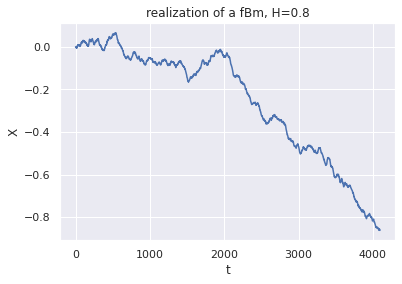

In [8]:
plt.plot(X)
plt.title('realization of a fBm, H=0.8')
plt.ylabel('X')
plt.xlabel('t')
# plt.savefig(figure_folder + 'realization.png')
plt.show()

## Power Spectral Density

Power spectral density analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [9]:
import pymultifracs.psd as psd

In [10]:
fs = 1

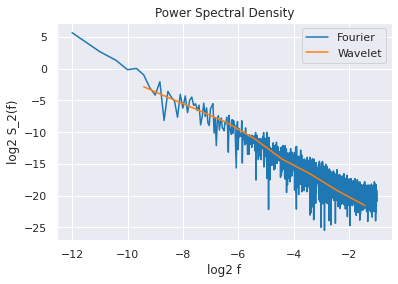

In [11]:
psd.plot_psd(X, fs, n_moments=2)

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

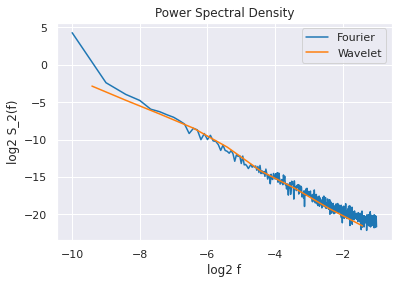

In [12]:
psd.plot_psd(X, fs, n_fft=1024)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

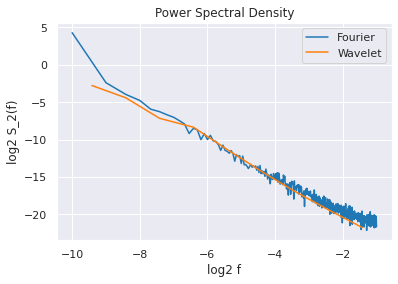

In [13]:
psd.plot_psd(X, fs, n_moments=3, n_fft=1024)
# plt.savefig(figure_folder + 'PSD_compare.png')

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [14]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [15]:
PSD.freq, PSD.psd

(array([0.375     , 0.1875    , 0.09375   , 0.046875  , 0.0234375 ,
        0.01171875, 0.00585938, 0.00292969, 0.00146484]),
 array([2.74237378e-07, 1.42364640e-06, 7.88128300e-06, 5.20288319e-05,
        3.86049789e-04, 3.06908282e-03, 6.98033133e-03, 4.69268065e-02,
        1.46664219e-01]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [22]:
from pymultifracs.wavelet import wavelet_analysis

TODO: detail the wavelet transform

In [23]:
WT = wavelet_analysis(X)

/home/md262764/Multifracs/pymultifracs/pymultifracs/wavelet.py:110: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 9
  warnings.warn("Value of j2 is higher than the maximum allowed level. "


The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

## Second order analysis

In [24]:
import pymultifracs.mfa as mfa

In [25]:
import numpy as np

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

The p_exponent parameters `p_exp` controls how wavelet leaders are used: if set to an int, it will use wavelet p-leaders, or if set to `np.inf`, it will use the wavelet leaders.

The output of the `mf_analysis_full` function contains two variables, `dwt` and `lwt`. The former contains the multifractal variables computed using the wavelet coefs, while the latter uses the wavelet leaders.

By default the `p_exp` parameter is set to `None`, which means the wavelet coefs only are used, and so the `lwt` variable returned is set to `None`

In [26]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
)

In [27]:
print(lwt)

None


**Unpacking dwt**

The variable dwt contains three fields: the structure functions, cumulants, multifractal spectrum, and hmin estimate. They can be unpacked all at once, or called one by one

In [28]:
sf, cumul, mfs, hmin = dwt

In [29]:
sf = dwt.structure
cumul = dwt.cumulants
mfs = dwt.spectrum
hmin = dwt.hmin

**H estimate**

In [53]:
sf.get_H()

0.811373735961043

**structure functions**

In [30]:
sf.j

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
sf.q

array([-2, -1,  0,  1,  2])

In [32]:
sf.formalism

'wavelet coef'

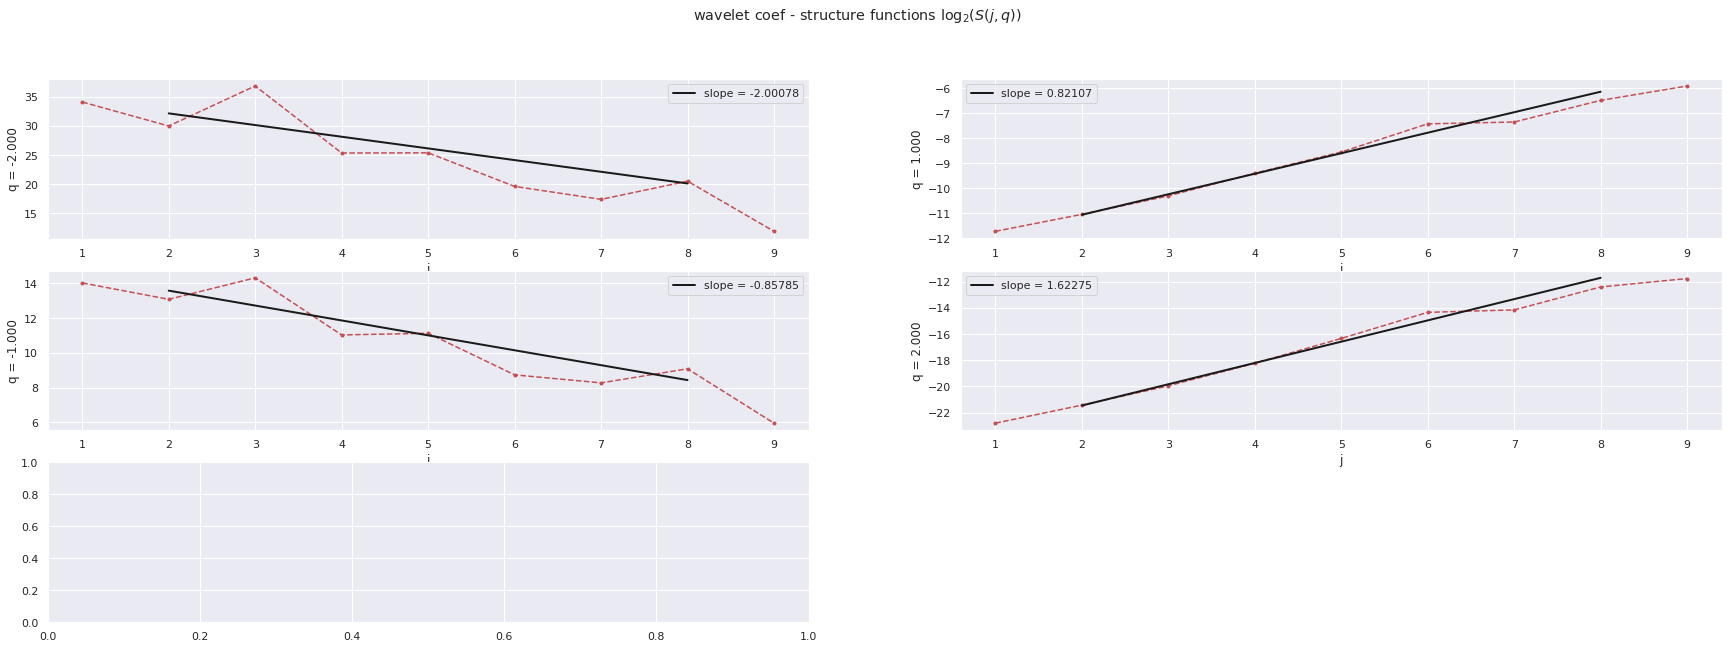

In [33]:
sf.plot(nrow=3)

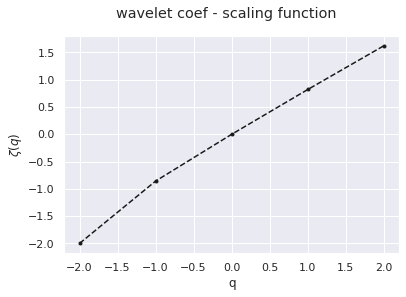

In [34]:
sf.plot_scaling()

**cumulants**

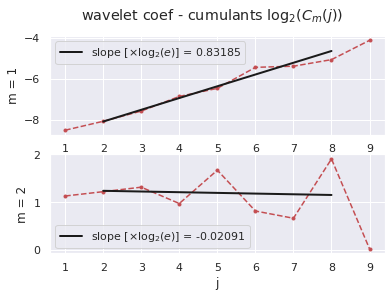

In [35]:
cumul.plot(nrow=3)

In [36]:
cumul.log_cumulants

array([ 0.8318544 , -0.02091305])

**multifractal spectrum**

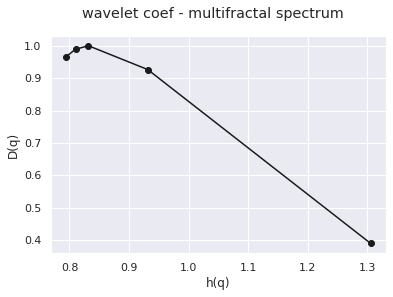

In [37]:
mfs.plot()

## Multifractal Analysis

**Using wavelet leaders**

In [54]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
    p_exp=np.inf
)

The `lwt` variable shares the same structure as `dwt`

In [55]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

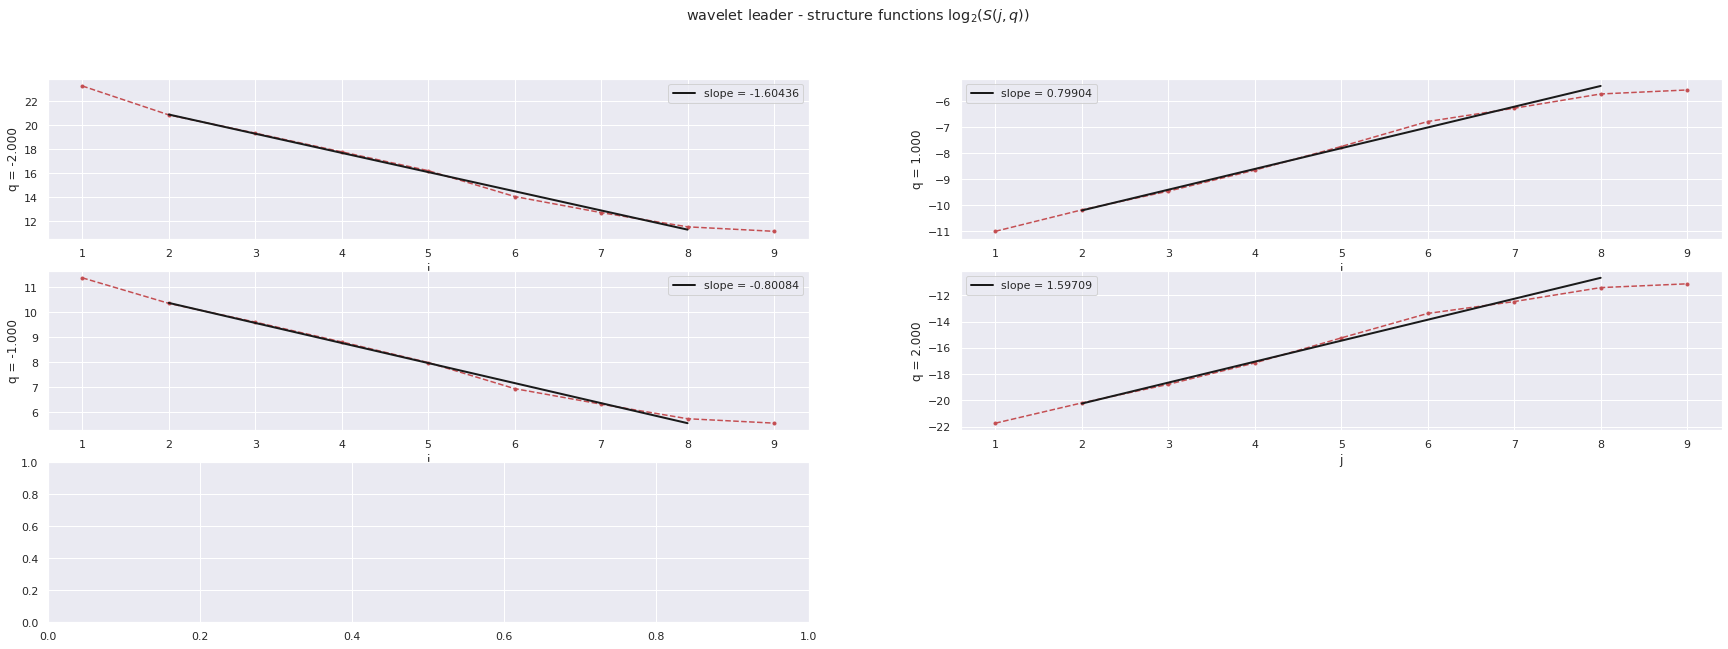

In [56]:
lwt_sf.plot(nrow=3)

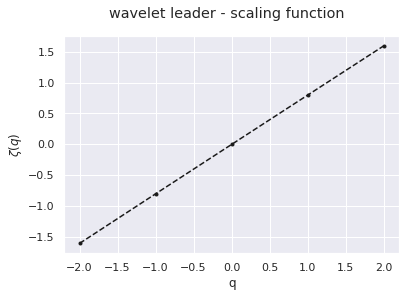

In [57]:
lwt_sf.plot_scaling()

**cumulants**

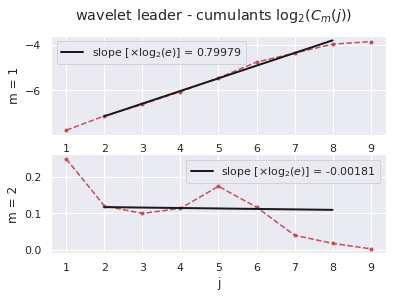

In [58]:
lwt_cumul.plot(nrow=3)

In [59]:
lwt_cumul.log_cumulants

array([ 0.79978736, -0.0018066 ])

**multifractal spectrum**

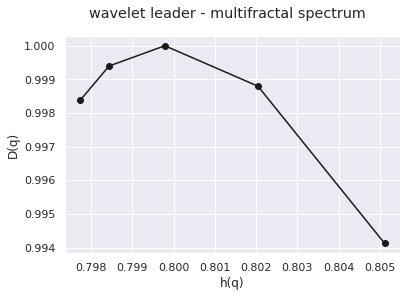

In [60]:
lwt_mfs.plot()

**Using p-leaders**

In [38]:
dwt, lwt = mfa.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
    p_exp=2
)

The `lwt` variable shares the same structure as `dwt`

In [39]:
lwt_sf, lwt_cumul, lwt_mfs, hmin = lwt

The `lwt_sf`, `lwt_cumul`, `lwt_mfs` variables defined here share the same structure as the `sf`, `cumul`, and `mfs` variables defined previously

**structure functions**

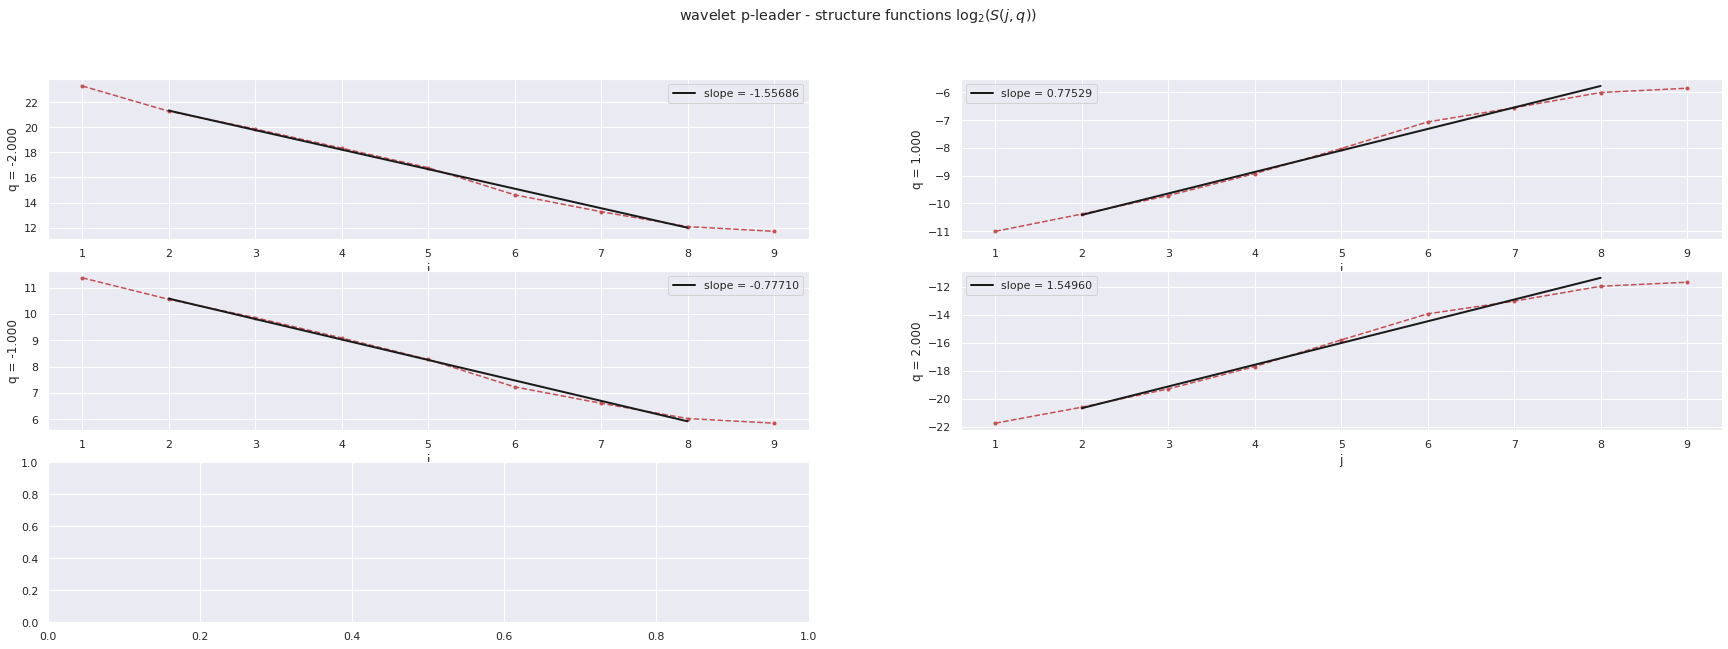

In [40]:
lwt_sf.plot(nrow=3)

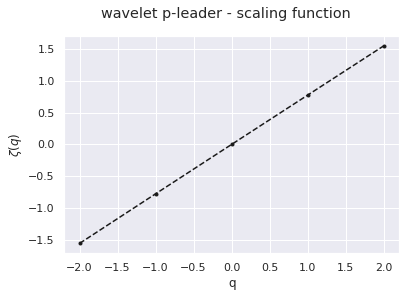

In [41]:
lwt_sf.plot_scaling()

**cumulants**

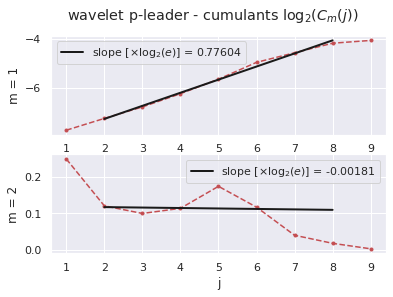

In [42]:
lwt_cumul.plot(nrow=3)

In [43]:
lwt_cumul.log_cumulants

array([ 0.77604071, -0.0018066 ])

**multifractal spectrum**

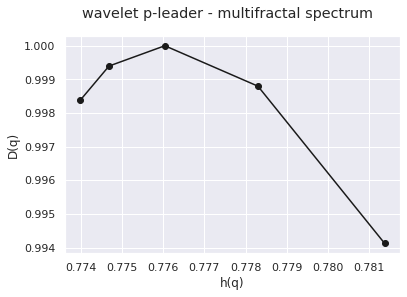

In [44]:
lwt_mfs.plot()

## Object oriented approach

The `Signal` dataclass offers an approach where the signal data and any intermediary results and parameters are kept in an instance

In [45]:
import pymultifracs.signal as sig

In [46]:
S = sig.Signal(X, fs, 'log')

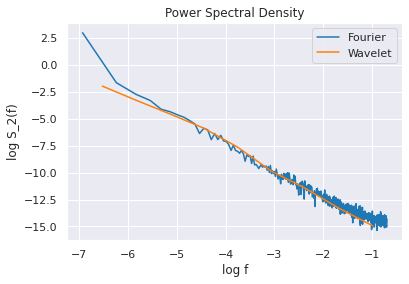

In [47]:
S.plot_psd(n_fft=1024)

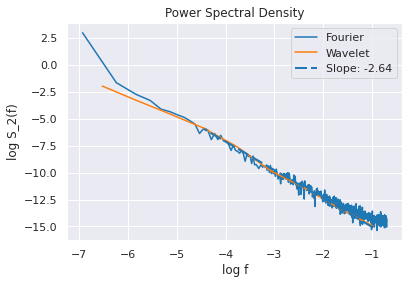

In [48]:
S.plot_fractal(n_fft=1024)

In [49]:
S.fractal_analysis()

FractalValues(beta=-2.636965583411659, log_C=-17.672781267199564, freq=array([[-0.98082925],
       [-1.67397643],
       [-2.36712361],
       [-3.06027079],
       [-3.75341798],
       [-4.44656516]]))

In [50]:
S.wt_psd

PSD(freq=array([0.375     , 0.1875    , 0.09375   , 0.046875  , 0.0234375 ,
       0.01171875, 0.00585938, 0.00292969, 0.00146484]), psd=array([3.22593437e-07, 1.65238215e-06, 1.05356363e-05, 5.18513183e-05,
       4.83054100e-04, 2.80120389e-03, 1.04822851e-02, 3.73118752e-02,
       1.39042162e-01]))

In [ ]:
S.welch_psd

In [52]:
S.fractal

FractalValues(beta=-2.636965583411659, log_C=-17.672781267199564, freq=array([[-0.98082925],
       [-1.67397643],
       [-2.36712361],
       [-3.06027079],
       [-3.75341798],
       [-4.44656516]]))